In [ ]:
# prompt: mount drive code

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Set path to your zip file
zip_path = "/content/drive/MyDrive/AI Dataset.zip"

# Set extraction directory
extract_to = "/content/AIDataset"

# Create directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Unzipped to: {extract_to}")


✅ Unzipped to: /content/AIDataset


Total images: 476, Shape: (128, 128)


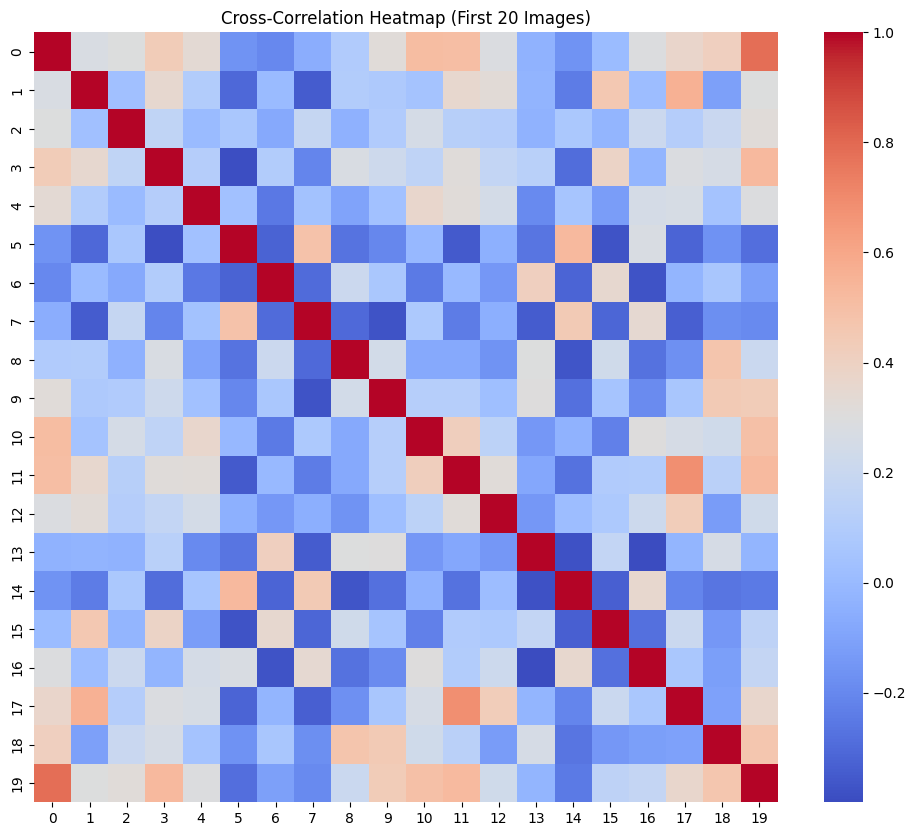

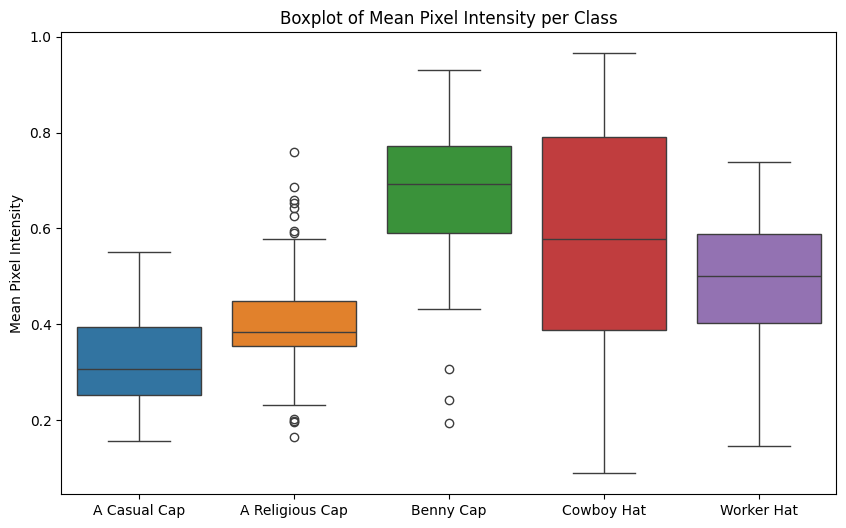

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.preprocessing import minmax_scale

# Parameters
IMAGE_SIZE = (128, 128)  # Resize dimensions
DATA_PATH = '/content/AIDataset/AI Dataset'  # Set your dataset folder path

# Create class-wise image dictionary
image_paths = glob(os.path.join(DATA_PATH, '*/*.jpg'))
class_dict = {}
for path in image_paths:
    label = path.split(os.sep)[-2]
    class_dict.setdefault(label, []).append(path)

# Preprocessing Function
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, IMAGE_SIZE)
    img_normalized = img_resized / 255.0
    return img_normalized

# Preprocess all images
processed_images = []
labels = []
for cls, paths in class_dict.items():
    for p in paths:
        processed = preprocess_image(p)
        processed_images.append(processed)
        labels.append(cls)

processed_images = np.array(processed_images)
labels = np.array(labels)

print(f"Total images: {len(processed_images)}, Shape: {processed_images[0].shape}")


# Cross-Correlation Analysis

def compute_cross_correlation(images):
    n = len(images)
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_matrix[i, j] = np.corrcoef(images[i].flatten(), images[j].flatten())[0, 1]
    return corr_matrix

# Sample 20 images for heatmap (to save time)
sample_images = processed_images[:20]
corr_matrix = compute_cross_correlation(sample_images)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Cross-Correlation Heatmap (First 20 Images)")
plt.show()


# Box Plot of Image Statistics

# Compute mean pixel intensity per image
mean_intensities = [img.mean() for img in processed_images]
class_stats = {}

for mean_val, cls in zip(mean_intensities, labels):
    class_stats.setdefault(cls, []).append(mean_val)

# Plot boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=[class_stats[cls] for cls in class_stats],
            orient='v')
plt.xticks(ticks=range(len(class_stats)), labels=list(class_stats.keys()))
plt.ylabel("Mean Pixel Intensity")
plt.title("Boxplot of Mean Pixel Intensity per Class")
plt.show()


✅ Data loaded
Total samples: 476
Class distribution: Counter({np.int64(3): 180, np.int64(4): 114, np.int64(1): 87, np.int64(0): 64, np.int64(2): 31})
Epoch 1/250 - Loss: 2.0768 - Train Acc: 25.79% - Test Acc: 41.67%
Epoch 10/250 - Loss: 1.1697 - Train Acc: 47.63% - Test Acc: 48.96%
Epoch 20/250 - Loss: 0.8519 - Train Acc: 66.32% - Test Acc: 57.29%
Epoch 30/250 - Loss: 0.7922 - Train Acc: 70.00% - Test Acc: 59.38%
Epoch 40/250 - Loss: 0.6788 - Train Acc: 74.47% - Test Acc: 61.46%
Epoch 50/250 - Loss: 0.5929 - Train Acc: 79.21% - Test Acc: 61.46%
Epoch 60/250 - Loss: 0.5156 - Train Acc: 84.47% - Test Acc: 59.38%
Epoch 70/250 - Loss: 0.4549 - Train Acc: 86.58% - Test Acc: 59.38%
Epoch 80/250 - Loss: 0.3995 - Train Acc: 88.95% - Test Acc: 59.38%
Epoch 90/250 - Loss: 0.3933 - Train Acc: 89.74% - Test Acc: 60.42%
Epoch 100/250 - Loss: 0.3430 - Train Acc: 92.63% - Test Acc: 59.38%
Epoch 110/250 - Loss: 0.3150 - Train Acc: 91.84% - Test Acc: 56.25%
Epoch 120/250 - Loss: 0.2833 - Train Acc: 94.

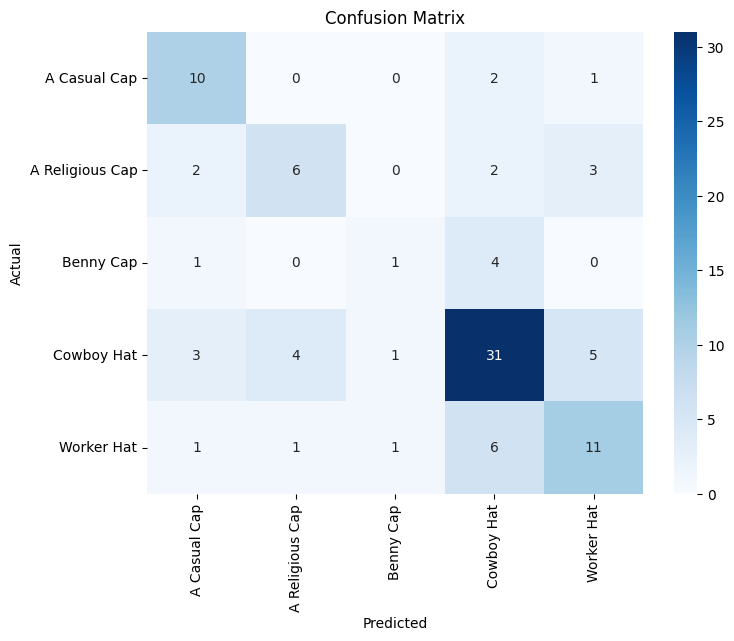

In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

# Set seed
np.random.seed(42)

# Parameters
IMAGE_SIZE = (64, 64)
DATA_PATH = '/content/AIDataset/AI Dataset'  # Change this to your dataset path
LEARNING_RATE = 0.01
EPOCHS = 250
HIDDEN_UNITS_1 = 256
HIDDEN_UNITS_2 = 128
DROPOUT_KEEP_PROB = 0.8

# Load and label images
image_paths = glob(os.path.join(DATA_PATH, '*/*.jpg'))
class_dict = {}
for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    class_dict.setdefault(label, []).append(path)

class_names = list(class_dict.keys())
class_to_index = {cls: i for i, cls in enumerate(class_names)}
num_classes = len(class_names)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, IMAGE_SIZE)
    return img_resized.flatten()

# Prepare dataset
X, y = [], []
for cls, paths in class_dict.items():
    for p in paths:
        X.append(preprocess_image(p))
        y.append(class_to_index[cls])

X = np.array(X, dtype=np.float32)
y = np.array(y)

print("\u2705 Data loaded")
print("Total samples:", len(X))
print("Class distribution:", Counter(y))

# Standardize input
mean = X.mean(axis=0)
std = X.std(axis=0) + 1e-8
X = (X - mean) / std

# Shuffle and split
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encoding
y_encoded = np.zeros((len(y), num_classes))
y_encoded[np.arange(len(y)), y] = 1

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_encoded[:split], y_encoded[split:]
y_test_labels = y[split:]

# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def dropout(x, keep_prob):
    mask = (np.random.rand(*x.shape) < keep_prob).astype(np.float32)
    return x * mask / keep_prob, mask

# Initialize weights
input_size = X.shape[1]
W1 = np.random.randn(input_size, HIDDEN_UNITS_1) * np.sqrt(2. / input_size)
b1 = np.zeros((1, HIDDEN_UNITS_1))
W2 = np.random.randn(HIDDEN_UNITS_1, HIDDEN_UNITS_2) * np.sqrt(2. / HIDDEN_UNITS_1)
b2 = np.zeros((1, HIDDEN_UNITS_2))
W3 = np.random.randn(HIDDEN_UNITS_2, num_classes) * np.sqrt(2. / HIDDEN_UNITS_2)
b3 = np.zeros((1, num_classes))

# Training loop with test accuracy
for epoch in range(1, EPOCHS + 1):
    # Forward pass
    Z1 = np.dot(X_train, W1) + b1
    A1 = relu(Z1)
    A1_drop, mask1 = dropout(A1, DROPOUT_KEEP_PROB)

    Z2 = np.dot(A1_drop, W2) + b2
    A2 = relu(Z2)
    A2_drop, mask2 = dropout(A2, DROPOUT_KEEP_PROB)

    Z3 = np.dot(A2_drop, W3) + b3
    A3 = softmax(Z3)

    loss = -np.sum(y_train * np.log(A3 + 1e-9)) / len(X_train)
    train_preds = np.argmax(A3, axis=1)
    train_labels = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_preds == train_labels)

    # Backpropagation
    dZ3 = A3 - y_train
    dW3 = np.dot(A2_drop.T, dZ3) / len(X_train)
    db3 = np.sum(dZ3, axis=0, keepdims=True) / len(X_train)

    dA2 = np.dot(dZ3, W3.T)
    dA2 *= mask2 / DROPOUT_KEEP_PROB
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1_drop.T, dZ2) / len(X_train)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_train)

    dA1 = np.dot(dZ2, W2.T)
    dA1 *= mask1 / DROPOUT_KEEP_PROB
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_train.T, dZ1) / len(X_train)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / len(X_train)

    # Update weights
    W3 -= LEARNING_RATE * dW3
    b3 -= LEARNING_RATE * db3
    W2 -= LEARNING_RATE * dW2
    b2 -= LEARNING_RATE * db2
    W1 -= LEARNING_RATE * dW1
    b1 -= LEARNING_RATE * db1

    # Evaluate on test set
    Z1_test = np.dot(X_test, W1) + b1
    A1_test = relu(Z1_test)
    Z2_test = np.dot(A1_test, W2) + b2
    A2_test = relu(Z2_test)
    Z3_test = np.dot(A2_test, W3) + b3
    A3_test = softmax(Z3_test)
    y_pred_test = np.argmax(A3_test, axis=1)
    test_accuracy = np.mean(y_pred_test == y_test_labels)

    if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
        print(f"Epoch {epoch}/{EPOCHS} - Loss: {loss:.4f} - Train Acc: {train_accuracy*100:.2f}% - Test Acc: {test_accuracy*100:.2f}%")

# Final evaluation
print(f"\n\u2705 Final Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true, pred in zip(y_test_labels, y_pred_test):
    conf_matrix[true, pred] += 1

print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
